# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- **THIS IS AN INDIVIDUAL ASSIGNMENT. Collaboration on this homework IS NOT PERMITTED.**

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [14 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Bagging [27 pts]**](#part2) 
  - [Solutions](#part2solutions)


- [**Question 3: Random Forests [14 pts]**](#part3) 
  - [Solutions](#part3solutions)


- [**Question 4: Boosting [30 pts]**](#part4) 
  - [Solutions](#part4solutions)


- [**Question 5: Understanding [15 pts]**](#part5) 
  - [Solutions](#part5solutions)
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [3]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [4]:
predictors = data_train.columns.values.tolist()
predictors = predictors[:-1]

In [5]:
len(predictors)

28

In [6]:
X_train

array([[ 0.377 , -1.58  , -1.71  , ...,  0.965 ,  1.31  ,  1.08  ],
       [ 0.707 ,  0.0876, -0.4   , ...,  2.22  ,  1.19  ,  0.938 ],
       [ 0.617 ,  0.266 , -1.35  , ...,  1.37  ,  0.982 ,  0.917 ],
       ...,
       [ 1.61  ,  0.432 , -0.116 , ...,  0.472 ,  0.775 ,  0.698 ],
       [ 1.53  , -0.475 ,  0.241 , ...,  0.841 ,  1.05  ,  0.881 ],
       [ 0.777 ,  0.91  ,  0.828 , ...,  0.812 ,  0.858 ,  0.878 ]])

<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [14 pts]</div> 
    
[Return to contents](#contents)
    
We will start by fitting a basic model that will serve as our "baseline" (i.e. a simple model that we can use as a starting point and can reasonably compare to other models). We will use a decision tree as our baseline model. We will later compare bagging, random forests, and boosting models in subsequent questions. We want a fair comparison, so it is important to keep important aspects of the experiments consistent (e.g. the data used to report train and test scores). We will tune the decision tree using cross-validation (of course). The hyper-parameter we will tune is the "maximum tree depth", which we will refer to as "depth" for simplicity.

Since we will only use tree-based methods in this homework, we do not need to scale our predictor or response variables. 

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set, while storing the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.
    
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracies on the train and test set. Store the train and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

**1.3** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth? 


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set, while storing the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

In [7]:

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

In [8]:
# your code here 

scores_list=[]
cv_scores = []
cvmeans = []
cvstds = []

for i in range(1,21):
    dtree = DecisionTreeClassifier(max_depth=i, random_state = i)
    dtree.fit(X_train, y_train)
    scores_list.append(dtree.score(X_train,y_train))
    cs = cross_val_score(dtree, X_train, y_train, cv = 5) 
    cv_scores.append(cs)
    
for j in cv_scores:
    cvmeans.append(j.mean())
    cvstds.append(j.std())

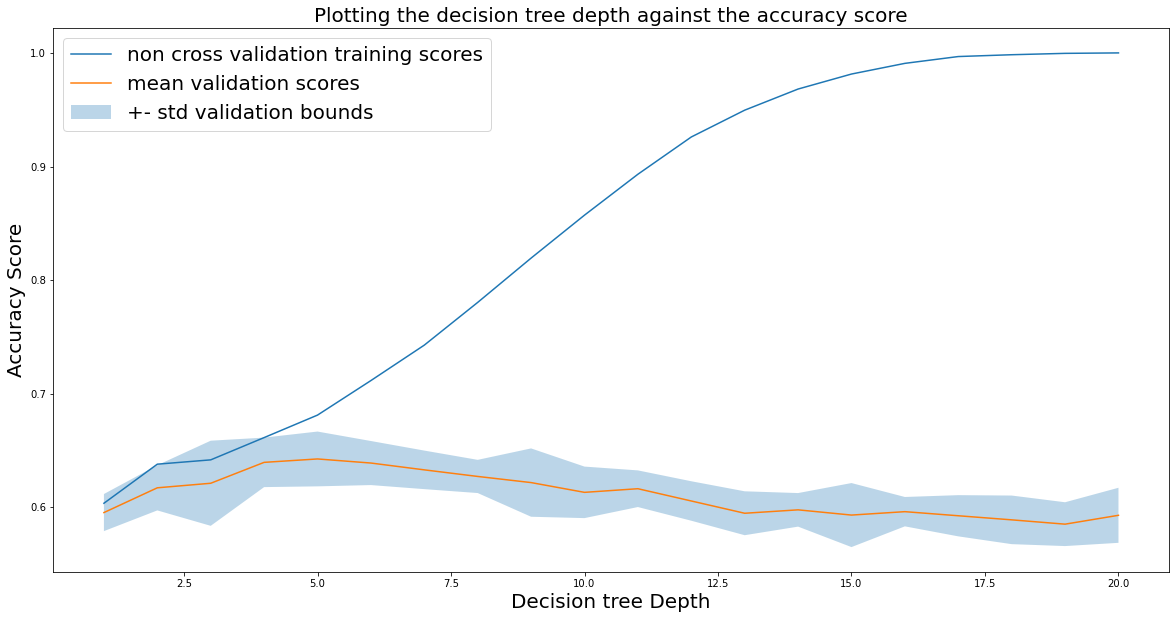

In [9]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(1,20,20), scores_list, label="non cross validation training scores")
plt.plot(np.linspace(1,20,20), cvmeans, label="mean validation scores")
means_array=np.asarray(cvmeans)
std_array = np.asarray(cvstds)
plt.fill_between(np.linspace(1,20,20), (means_array - 2*std_array) , ( means_array + 2*std_array), label="+- std validation bounds", alpha = 0.3) #fill between 
plt.title("Plotting the decision tree depth against the accuracy score", size = 20)
plt.ylabel("Accuracy Score", size = 20)
plt.xlabel("Decision tree Depth", size = 20)
plt.legend(fontsize = 20)
plt.show()







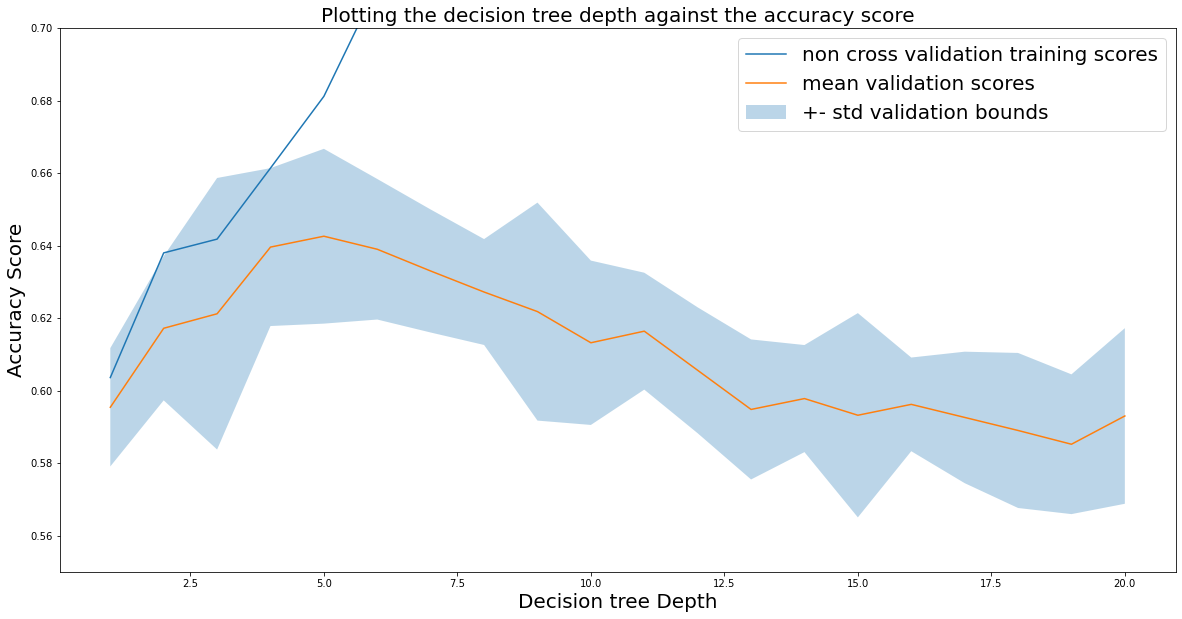

In [10]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(1,20,20), scores_list, label="non cross validation training scores")
plt.plot(np.linspace(1,20,20), cvmeans, label="mean validation scores")
means_array=np.asarray(cvmeans)
std_array = np.asarray(cvstds)
plt.fill_between(np.linspace(1,20,20), (means_array - 2*std_array) , ( means_array + 2*std_array), label="+- std validation bounds", alpha = 0.3) #fill between 
plt.title("Plotting the decision tree depth against the accuracy score", size = 20)
plt.ylabel("Accuracy Score", size = 20)
plt.xlabel("Decision tree Depth", size = 20)
plt.ylim(0.55,0.7)
plt.legend(fontsize = 20)
plt.show()





<div class='exercise-r'>

**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracies on the train and test set. Store the train and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

In [11]:
# your code here

# the best depth is the one that maximises the accuracy cvmeans
highest_accuracy = max(cvmeans)
best_depth = cvmeans.index(highest_accuracy)+1 #this is the best depth, which is 5
print("The best depth is the depth that maximises the accuracy, this is the depth of : ", best_depth,". This depth leads to the accuracy of : ", highest_accuracy*100, "%")

new_tree = DecisionTreeClassifier(max_depth=best_depth)
new_tree.fit(X_train,y_train)
best_cv_tree_train_score = new_tree.score(X_train, y_train)
best_cv_tree_test_score = new_tree.score(X_test, y_test)

print(f"The accuracy on the training dataset of the decision tree with the best depth of 5 is {best_cv_tree_train_score:.4f}")
print(f"The accuracy on the testing dataset of the decision tree with the best depth of 5 is {best_cv_tree_test_score:.4f}")



The best depth is the depth that maximises the accuracy, this is the depth of :  5 . This depth leads to the accuracy of :  64.26 %
The accuracy on the training dataset of the decision tree with the best depth of 5 is 0.6812
The accuracy on the testing dataset of the decision tree with the best depth of 5 is 0.6478


In [12]:
# the best depth is the one that maximises the accuracy cvmeans
lowest_accuracy = min(cvmeans)
worst_depth = cvmeans.index(lowest_accuracy)+1 #this is the best depth, which is 5
print("The worst depth is the depth that minimizes the accuracy, this is the depth of : ", worst_depth,". This depth leads to the accuracy of : ", lowest_accuracy*100, "%")

new_tree = DecisionTreeClassifier(max_depth=worst_depth)
new_tree.fit(X_train,y_train)
worst_cv_tree_train_score = new_tree.score(X_train, y_train)
worst_cv_tree_test_score = new_tree.score(X_test, y_test)

print(f"The accuracy on the training dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_train_score:.4f}")
print(f"The accuracy on the testing dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_test_score:.4f}")

The worst depth is the depth that minimizes the accuracy, this is the depth of :  19 . This depth leads to the accuracy of :  58.52 %
The accuracy on the training dataset of the decision tree with the worst depth of 19 is 0.9998
The accuracy on the testing dataset of the decision tree with the worst depth of 19 is 0.6070


**1.2 explanation:**

The list of values cvmeans is a list with 20 elements where each element is the accuracy mean calculated as the mean of 5 validation accuracy scores. Per depth from 1 to 20 we have an accuracy score (coming from the mean of 5 cross validated scores). 

It is important to look at the validation score and not at the training scores because the validation scores tell you how your model performed on you "test", which is what we aim to improve. The training scores cannot be taken as reference, because we see from the first plot above that the higher the depth, the higher the accuracy - which means that the train is getting more overfit as more depth is added to the tree - which is waht we want to avoid. We do not want to overfit to the training dataset.

This means that the **best** depth is the depth that has the highest accuracy mean from the validation. Consequently, max(cvmeans) gives us the **highest accuracy** possible. By looking at the index of this (+1 because in python indexing starts at 0), we will find the best depth.

The worst depth comes from using the same fashion of reasoning. Simply I look at the worst accuracy, i.e. at the minimum value in the cvmeans list. That will lead me to the worst depth possible.


<div class='exercise-r'>

**1.3** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

* Limiting tree depth avoids overfitting: limiting the depth of the tree is limiting the amount of noise from the training dataset that the tree is going to pick up from. By choosing a lower depth, we are fitting on less noise, hence we are going to avoid over-fitting.

* Downlide of limiting tree depth: we might incur into underfitting. The downside is that by trying to avoid the noise, the model might also end up avoiding picking up essential trends from the dataset. This will harm the prediction on the test dataset. 



<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [27 pts]</div> 

[Return to contents](#contents)

Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question, we build an example by hand and study how the number of bootstrapped datasets impacts the resulting classification accuracy.


**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- First, complete the `bagger` function based on the function's signature and docstring provided in the code cell below.
- Then, make a single call to that function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**REQUIRED DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps should be returned by the `bagger` function as dataframes formatted like the example shown below. Each row should represent one observation (from either the training or test set depending on the dataframe), and each column should represent one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

As an example, the required structure of the `bagging_train_df` and `bagging_test_df` dataframes is:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

**HINT:** You can use `resample(...)` from scikit-learn to easily bootstrap the $X$ and $y$ data.

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`. What accuracy does this "bagging" model achieve on the training and test sets? Using Python's `assert` keyword, write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in [Question 1](#part1solutions).

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

**2.7** In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

In [13]:
# your code here


# the best depth is the one that maximises the accuracy cvmeans
lowest_accuracy = min(cvmeans)
worst_depth = cvmeans.index(lowest_accuracy)+1 #this is the best depth, which is 5
print("The worst depth is the depth that maximises the accuracy, this is the depth of : ", worst_depth,". This depth leads to the accuracy of : ", lowest_accuracy*100, "%")


new_tree = DecisionTreeClassifier(max_depth=worst_depth)
new_tree.fit(X_train,y_train)
worst_cv_tree_train_score = new_tree.score(X_train, y_train)
worst_cv_tree_test_score = new_tree.score(X_test, y_test)

print(f"The accuracy on the training dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_train_score:.4f}")
print(f"The accuracy on the testing dataset of the decision tree with the worst depth of {worst_depth} is {worst_cv_tree_test_score:.4f}")



The worst depth is the depth that maximises the accuracy, this is the depth of :  19 . This depth leads to the accuracy of :  58.52 %
The accuracy on the training dataset of the decision tree with the worst depth of 19 is 0.9998
The accuracy on the testing dataset of the decision tree with the worst depth of 19 is 0.5976


**2.1 explanation:**

The list of values cvmeans is a list with 20 elements where each element is the accuracy mean calculated as the mean of 5 validation accuracy scores. Per depth from 1 to 20 we have an accuracy score (coming from the mean of 5 cross validated scores). 

It is important to look at the validation score and not at the training scores because the validation scores tell you how your model performed on you "test", which is what we aim to improve. The training scores cannot be taken as reference, because we see from the first plot above that the higher the depth, the higher the accuracy - which means that the train is getting more overfit as more depth is added to the tree - which is what we want to avoid. We do not want to overfit to the training dataset.

This means that the **worst depth** is the depth that has the **lowest accuracy mean** from the validation. Consequently, min(cvmeans) gives us the lowest accuracy possible. By looking at the index of this (+1 because in python indexing starts at 0), we will find the **worst** depth.




<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- First, complete the `bagger` function based on the function's signature and docstring provided in the code cell below.
- Then, make a single call to that function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**REQUIRED DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps should be returned by the `bagger` function as dataframes formatted like the example shown below. Each row should represent one observation (from either the training or test set depending on the dataframe), and each column should represent one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

As an example, the required structure of the `bagging_train_df` and `bagging_test_df` dataframes is:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

**HINT:** You can use `resample(...)` from scikit-learn to easily bootstrap the $X$ and $y$ data.

</div>

In [14]:
# Complete this function as instructed
# Do not modify the function signature or docstring
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    # your code here
    np.random.seed(random_seed)
    print(np.random.seed)


    bagging_models_list = []
    bagging_train_df = pd.DataFrame()
    bagging_test_df = pd.DataFrame()
    
    for i in range(0, n_trees):
        resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        
        # Get a bootstrapped version of the data using the above indices
        X_boot_train = X_train[resample_indexes]
        y_boot_train = y_train[resample_indexes]
    

        clf = DecisionTreeClassifier(max_depth = tree_depth) 
        clf.fit(X_boot_train, y_boot_train)
        
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)


        bagging_train_df[f'bootstrap_model_{i}'] = y_pred_train
        bagging_test_df[f'bootstrap_model_{i}'] = y_pred_test


        
        bagging_models_list.append(clf)
        
        

    
    # end of your code here
    
    return bagging_train_df, bagging_test_df, bagging_models_list
     

In [15]:
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees=  55,
    tree_depth=  worst_depth,
    X_train= X_train,
    y_train=  y_train,
    X_test=  X_test,
    random_seed=  0)

<built-in method seed of numpy.random.mtrand.RandomState object at 0x7fc9e203e240>


In [16]:
# your code here
bagging_train_df

,bootstrap_model_0,bootstrap_model_1,bootstrap_model_2,bootstrap_model_3,bootstrap_model_4,bootstrap_model_5,bootstrap_model_6,bootstrap_model_7,bootstrap_model_8,bootstrap_model_9,bootstrap_model_10,bootstrap_model_11,bootstrap_model_12,bootstrap_model_13,bootstrap_model_14,bootstrap_model_15,bootstrap_model_16,bootstrap_model_17,bootstrap_model_18,bootstrap_model_19,bootstrap_model_20,bootstrap_model_21,bootstrap_model_22,bootstrap_model_23,bootstrap_model_24,bootstrap_model_25,bootstrap_model_26,bootstrap_model_27,bootstrap_model_28,bootstrap_model_29,bootstrap_model_30,bootstrap_model_31,bootstrap_model_32,bootstrap_model_33,bootstrap_model_34,bootstrap_model_35,bootstrap_model_36,bootstrap_model_37,bootstrap_model_38,bootstrap_model_39,bootstrap_model_40,bootstrap_model_41,bootstrap_model_42,bootstrap_model_43,bootstrap_model_44,bootstrap_model_45,bootstrap_model_46,bootstrap_model_47,bootstrap_model_48,bootstrap_model_49,bootstrap_model_50,bootstrap_model_51,bootstrap_model_52,bootstrap_model_53,bootstrap_model_54
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
4996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4997,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4998,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
bagging_train_df1, bagging_test_df1, bagging_models_list1 = bagger(
    n_trees=  55,
    tree_depth=  worst_depth,
    X_train= X_train,
    y_train=  y_train,
    X_test=  X_test,
    random_seed=  0)

<built-in method seed of numpy.random.mtrand.RandomState object at 0x7fc9e203e240>


In [18]:
bagging_train_df1 == bagging_train_df

,bootstrap_model_0,bootstrap_model_1,bootstrap_model_2,bootstrap_model_3,bootstrap_model_4,bootstrap_model_5,bootstrap_model_6,bootstrap_model_7,bootstrap_model_8,bootstrap_model_9,bootstrap_model_10,bootstrap_model_11,bootstrap_model_12,bootstrap_model_13,bootstrap_model_14,bootstrap_model_15,bootstrap_model_16,bootstrap_model_17,bootstrap_model_18,bootstrap_model_19,bootstrap_model_20,bootstrap_model_21,bootstrap_model_22,bootstrap_model_23,bootstrap_model_24,bootstrap_model_25,bootstrap_model_26,bootstrap_model_27,bootstrap_model_28,bootstrap_model_29,bootstrap_model_30,bootstrap_model_31,bootstrap_model_32,bootstrap_model_33,bootstrap_model_34,bootstrap_model_35,bootstrap_model_36,bootstrap_model_37,bootstrap_model_38,bootstrap_model_39,bootstrap_model_40,bootstrap_model_41,bootstrap_model_42,bootstrap_model_43,bootstrap_model_44,bootstrap_model_45,bootstrap_model_46,bootstrap_model_47,bootstrap_model_48,bootstrap_model_49,bootstrap_model_50,bootstrap_model_51,bootstrap_model_52,bootstrap_model_53,bootstrap_model_54
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4996,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4997,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4998,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`. What accuracy does this "bagging" model achieve on the training and test sets? Using Python's `assert` keyword, write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in [Question 1](#part1solutions).

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

In [19]:
# your code here

# Here I aggregate
aggregated_train = bagging_train_df.mean(axis=1)
aggregated_test = bagging_test_df.mean(axis=1)

# Here i make them 0 and 1
aggregated_pred_train_classified = (aggregated_train >= 0.5).astype(int)
aggregated_pred_test_classified = (aggregated_test >= 0.5).astype(int)


In [20]:
# Here i can compare things

# Note for myself, I could do this more quickly with : (y == y_pred).mean()
matches_vector_train = (y_train == aggregated_pred_train_classified).astype(int)
bagging_accuracy_train = sum(matches_vector_train)/len(matches_vector_train)
# assert bagging_accuracy_train >=best_cv_tree_train_score

matches_vector_test = (y_test == aggregated_pred_test_classified).astype(int)
bagging_accuracy_test = sum(matches_vector_test)/len(matches_vector_test)
assert bagging_accuracy_test >=best_cv_tree_test_score



<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

</div>

In [21]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "baggin_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


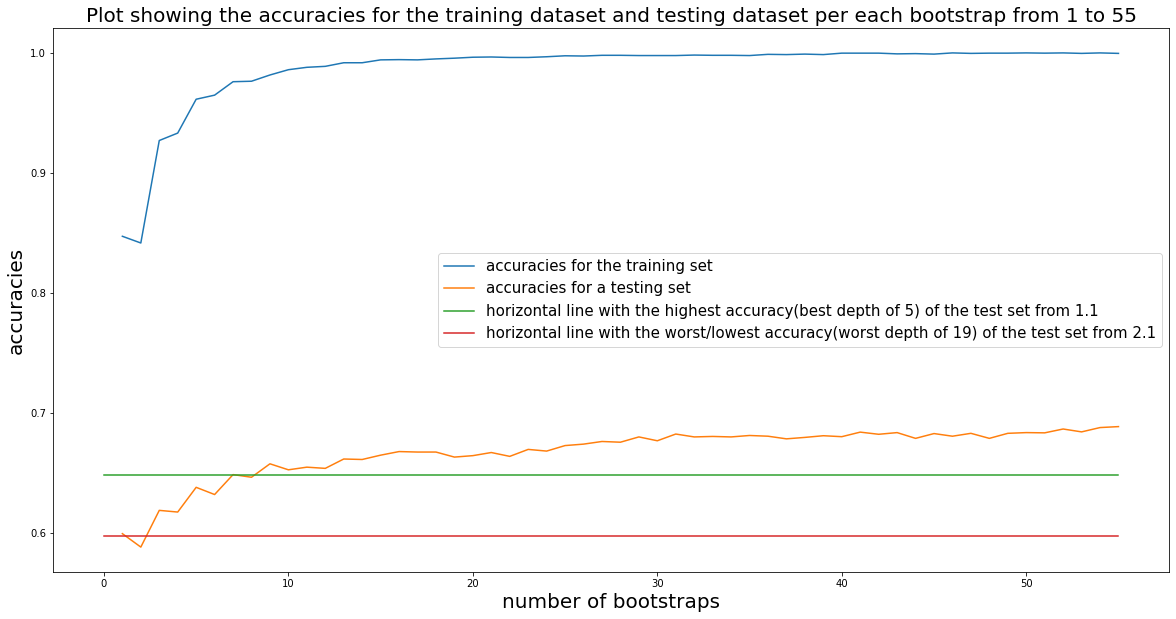

In [22]:
# your code here

accuracy_train_per_boot = []
accuracy_test_per_boot = []

accuracy_train_per_boot = running_predictions(bagging_train_df, y_train)
accuracy_test_per_boot = running_predictions(bagging_test_df, y_test)


plt.figure(figsize = (20,10))
plt.title("Plot showing the accuracies for the training dataset and testing dataset per each bootstrap from 1 to 55", size = 20)
plt.plot(np.linspace(1,55, 55), accuracy_train_per_boot, label = "accuracies for the training set")
plt.plot(np.linspace(1,55, 55), accuracy_test_per_boot, label = "accuracies for a testing set")
plt.plot((0,55), (best_cv_tree_test_score,best_cv_tree_test_score), label = "horizontal line with the highest accuracy(best depth of 5) of the test set from 1.1")
plt.plot((0,55), (worst_cv_tree_test_score,worst_cv_tree_test_score), label = "horizontal line with the worst/lowest accuracy(worst depth of 19) of the test set from 2.1")


plt.ylabel("accuracies", size=20)
plt.xlabel("number of bootstraps", size=20)
plt.legend(fontsize = 15)
plt.show()



<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

</div>

**Comparing differences:**

Although Bagging still overfits (because the divergence between testing and training scores is quite sheer), IF we have enough boostraps we can even outperform the performance of even a very good decision tree.  

We see that the performence of the tree with depth 19 is lower than the performance of the tree with depth 5. This is something expected, as the tree with depth 19 overfits to the training dataset, hence it is expected that would do poorly on the test set. 

However, we can see that if we combine together many trees that might perform poorly on their own, depending how many bootstraps we do, we can see that if we do enough bootstraps( here in this case, at least 10), the bagging model (made of 'bad' trees that overfit on their own) can still beat the performance of even the best tree we fitted in problem 1.1

<div class='exercise-r'>

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

</div>



**Limiting a tree depth:**
* If I limit a tree depth, I am preventing the model from getting any complexity.

**Bagging:**
* in bagging I am not limiting the tree depth, to the opposite. 
* in bagging I am starting from a very complex model to then scale down.
* In ML usually it is better to start from a complex model to then reduce its noise. The whole idea of redularization follows this principle too, i.e. starting with a complex model to then reduce it. Similarly, pruning follows this same structure.
* Consequently, starting off from a more complex model can be better because more details are picked up from the mode. With a shallow tree, you are might be underfitting to the extend that you might be preventing the model to not only avoid noise but to also avoid major trends on the dataset. 


**Comparing bagging and limiting tree depth to preven overfitting:**

Despite the overfitting, bagging can still outperform an ideal single decision tree with an ideal depth. However, this is not always the case. Meaning, that bagging can even do worse than a poor single decision tree with poor performance and high depth, if there are too few bootstraps. --> Bagging will outperform a single ideal model only if it performes enough bootstraps. 

On the other hand, limiting the depth of a tree reduces how a model overfits. Nevertheless, some trends on the train might be simply lost and might not be picked up at all. Consequently, its performance might still be beaten by another model that overfits and that is able to pick up on more trends from the trainining dataset. This other model can be bagging. 

Bagging is made of many trees that pick as much info as possible from the dataset. Additionally, this dataset changes every time (it comes from random boostraps from the training dataset). This means that each tree has some noise as well as some essential trends. By not scratching/cutting the depth, we pick up on everything every time, just on different things everytime, due to the randomess of the bootstraps. If we take what these have in coommon (i.e. aggregate), we will be able to look at which trends that all these 55 trees have found. Consequently,  the trends found by the bagging can be more than the trends found by the single decision tree with "ideal depth" - because we decide not to exclude anything. We take as much as possible, and then pick the aggregation of all this. 

That's why, if we have enough bootstraps, even if there is overfitting, a bagging model can still outperform an ideal tree.

<div class='exercise-r'>

**2.7** In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

</div>


* **We didn't cross validate to find the best depth to do bagging with:** Here we didnt cross validate to find the best depth. If the depth is too high, it might still overfit, as we are bootstrapping with many high density trees. If the depth is too low, it might undersfit, as we are boostrapping with many low density trees.
    * **Overfitting:** We might overfit to the data if the depth is way too high. IF we pick a sufficently depth tree, we are not underfitting. IF we pick a low depth, we are underfitting with bagging. But again, the 'sufficient' depth is to be determined with CV.

    * **Underfitting:** Same as above. Additionally, we have in total 28 predictors, not 20. We have chose the max depth to be 20 in this problem set, however to actually grasp each predictor we would need a depth of 28. In that sense, we might be underfitting in our bagging process. But again, the 'sufficient' depth is to be determined with CV.





<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

Random forests are closely related to the bagging model we built by hand in Question 2. In this question, we will compare our bagging results with the results of using scikit-learn's `RandomForestClassifier`.

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate and report this classifier's accuracy on the training and test sets. Then, assign those accuracies to the variables `random_forest_train_score` and `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a Pandas table (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |


<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate and report this classifier's accuracy on the training and test sets. Then, assign those accuracies to the variables `random_forest_train_score` and `random_forest_test_score`.

</div>

In [23]:
print(f"The worst depth is {worst_depth}")

The worst depth is 19


In [24]:
# your code here
forest = RandomForestClassifier(max_depth = worst_depth, n_estimators = 55) #, random_state=2)  #number of tree is the number of estimators
forest.fit(X_train, y_train)

random_forest_train_score = forest.score(X_train, y_train)
random_forest_test_score = forest.score(X_test, y_test)

print(f"The random forest train score is : {random_forest_train_score}")
print(f"The random forest test score is : {random_forest_test_score}")


The random forest train score is : 1.0
The random forest test score is : 0.6898


<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

</div>

In [25]:
### Notes for myself:
#forest.estimators_[0] #first tree of the random forest
#range(len(forest.estimators_))
#bagging_models_list[0]# first tree of the bagging
#len(bagging_models_list) # i have 55 trees in by bagging model
#forest.estimators_[1].tree_.feature[0]  #first feature of the second tree of the random forest
#bagging_models_list[0].tree_.feature[0] #first feature of the first tree in my bagging model

#count_list_features_bagging
#max(count_list_features)
#count_list_features.index(max(count_list_features))

In [26]:
count_list_features = [0] * 28
for i in range(len(forest.estimators_)):
    for j in range(len(count_list_features)):
        forest.estimators_[j].tree_.feature[0]
        if forest.estimators_[i].tree_.feature[0] == j:
            count_list_features[j] +=1
     

In [27]:
count_list_features_bagging = [0] * 28
for i in range(len(bagging_models_list)):
    for j in range(len(count_list_features)):
        bagging_models_list[j].tree_.feature[0]
        if bagging_models_list[i].tree_.feature[0] == j:
            count_list_features_bagging[j] +=1


In [28]:
predictors_list = predictors.copy()

In [29]:
count_features = pd.DataFrame()
count_features['predictors'] = predictors_list
count_features['how many times this feature was the top node in Random forest'] = count_list_features
count_features['how many times this feature was the top node in bagging'] = count_list_features_bagging

sorted_count = count_features.sort_values(by='how many times this feature was the top node in Random forest', ascending=False)
sorted_count

,predictors,how many times this feature was the top node in Random forest,how many times this feature was the top node in bagging
27,m_wwbb,11,0
26,m_wbb,11,0
22,m_jjj,7,0
3,missing energy magnitude,5,0
25,m_bb,5,55
9,jet 2 pt,3,0
12,jet 2 b-tag,2,0
5,jet 1 pt,2,0
6,jet 1 eta,2,0
1,lepton eta,2,0


**Top predictors explanation:**

* **Bagging** is only doing boostrapping of the dataset. Meaning, that although is selecting rows from the dataset randomly every time to create new bootstrapped datasets, at each bootstrap bagging is selecting all predictors every time. Hence, the set of predictors at each bootstrap is the same. Meaning, that the best predictor won't change, and that will be the same 'best' split predictor every time, i.e. at the top node every time. 

* **Random Forest** does **2** random selections. 
    * **1.** The first random selection is the selection of the rows, i.e. the boostrap of the dataset in many new randomly selected datasets. 
    * **2.** The second random selection (which happens at each boostrap) is the selection of the columns, i.e. the selection of the predictors. Random Forest is selecting every time at each random bootstrap iteration a new subset of predictors. The amount of predictors picked in this case chosen is the square root of the total number of features. Given that there is a subset of predictors chosen every time, the top predictor will be different every time. Given this, every time the 'best' split, i.e. the top node, will be different every time, because we pick a different subset of predictors every time.



Consequently, **RF** is better ad de-correlating the trees and is better at reducing the variance bc the trees are mode de-correlated due to picking different random estimators. 

A small exception to this is that if we find ourselves in the unfortunate situations where most predictors are bad/useless. In that case, RF would not perform ideally as expected. In that edge case, then we would have to do first model selection (with lasso for example), and then apply RF. 





<div class='exercise-r'>

**3.3**: Make a Pandas table (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

In [30]:
# your code here

table = pd.DataFrame()
table['classifier'] = ['single depth-5 tree chosen by CV', 'single overfit depth-19 tree', 'bagging 55 depth-19 trees', 'random forest of 55 depth-19 trees']
table['training accuracy'] = [best_cv_tree_train_score, worst_cv_tree_train_score,bagging_accuracy_train,  random_forest_train_score]
table['test accuracy'] = [best_cv_tree_test_score,worst_cv_tree_test_score, bagging_accuracy_test, random_forest_test_score ]
table

,classifier,training accuracy,test accuracy
0,single depth-5 tree chosen by CV,0.6812,0.6478
1,single overfit depth-19 tree,0.9998,0.5976
2,bagging 55 depth-19 trees,0.9994,0.6884
3,random forest of 55 depth-19 trees,1.0000,0.6898


**What is the relative performance of each model on the training set? On the test set?**

* Single depth-5 tree chosen by CV: this tree has a testing accuracy that is lower than the training accuracy, as expected.

* Single overfit depth-19 tree: The training accuracy of the single depth-5 tree is lower than the training accuracy of the single overfit depth-19 tree. This makes sense because the depth-19 tree is overfitting on the trainind dataset and picking up on all the noise from the training dataset. Hence the depth-19 tree describes the training dataset better than what the depth-5 tree does. However, the depth-19 tree performs worse than the depth-5 tree on the testing dataset. Meaning, that the accuracy of the depth-19 tree (0.6004) is lower than the accuracy of the single depth-5 tree (0.6482) on the testing dataset, as expected.

* Bagging: this performs on the testing worse than on the training, as expected. However, the score of the test beats the score of the two individual trees, even the "best" one. This shows how the aggregation of many "bad" models, can beat a single good one.

* RF: this performs on the testing worse than on the training, as expected.  However, the score of the test beats the score of the two individual trees, even the "best" one. This shows how the aggregation of many "bad" models, can beat a single good one.

**Comment on how these relationships make sense (or dont make sense) in light of how each model treats the bias-variance tradeoff.**

* Both bagging and RF outperform (have higher accuracy) the single depth-5 tree on the testing set. This is a very exceptional result, because on the training dataset, due to the nature of picking high-depth trees, both bagging and RF are almost completely overfitting (accuracy score close to 1). 

* Despite both bagging and RF  overfitting on the training dataset, this doesnt't spillover on the testing dataset performance, due to aggregation (bagging, random forest) and features selection (random forest only). 

* Bagging selects many trees that have high depth from several bootstraps with all the predictors every time, i.e. just  predictor will be the dominant best split predictor. As explained above, with enough bootstraps, this model can outperform on the testing dataset the single best depth-5 tree chosen by the CV. 

* RF also create a high-depth tree at every bootstraps but with additionally also selecting a dubset of predictors every time at every bootstrap, meaning that there will not be a single best split predictor, but rather a best one at every subset. Due to this, RF is able to beat bagging performance on the testing dataset, beacuse RF is more capable than bagging to de-correlated the trees.  The testing accuracy of the RF, 0.6898 is higher than the testing accuracy of the bagging 0.6884. 


**Conclusion:**

* RF predicts the testing dataset the best, due to how RF is able to have more de-correlated trees compared to bagging. RF does bootstrapping + selection of subset of predictors VS bagging does only bootstrapping with no predictors selection.
* Both RF and bagging outperform a single tree with ideal depth. Although RF and Bagging both start from overfitting (high variance and low bias), they both reduce tha variance and increase the bias through aggregation (averaging). And although they start off with "bad" and "worse" trees, they can still beat the "best" tree with "best" depth of 5. 



<a id="part4"></a>

## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

In this question, we explore a different kind of ensemble method, boosting. Each new model is trained on a dataset weighted towards observations that the current model predicts incorrectly. 

We will focus on the AdaBoost flavor of boosting and examine the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes:

- Fit `tree1`, a decision tree of depth-3, to the training data. 

- Report the train and test accuracies. 

- For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. 

- Do you notice any predictors for which the distributions are clearly different?
    
**HINTS:**
- The use of subplots using `plt.subplots(...)` will make this plotting exercise easier to code and will help you to present these visuals in a cleaner, easier to view manner.
- You may find [`sns.kdeplot(...)`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) useful for this exercise. If you do use it, please note from the Seaborn documentation that `sns.kdeplot` takes `ax` as a parameter.

**4.2** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

**4.3** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.2:

- Write an excellent example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**4.4** Now, let us use the scikit-learn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and test accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

**4.5** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. Therefore, you should end up with 4 separate plots or subplots. What trends do you see in the training and test accuracy?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

**4.6** Answer the following interpretive questions. The use of code is optional here, but should be used if you find it is needed to answer any of these questions. 


- **4.6.1** Based on the plots from Question 4.5, what combination of base learner depth and the number of iterations seems optimal and why? 


- **4.6.2** Why should we be hesitant to select our learner depth and number of iterations hyperparameters based on our inspection of these train and test results? What are the risks of doing so? 


- **4.6.3** Setting those risks aside, if you do select the base learner depth and number of iterations based on those plots, how does the performance of that model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?


<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes:

- Fit `tree1`, a decision tree of depth-3, to the training data. 

- Report the train and test accuracies. 

- For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. 

- Do you notice any predictors for which the distributions are clearly different?
    
**HINTS:**
- The use of subplots using `plt.subplots(...)` will make this plotting exercise easier to code and will help you to present these visuals in a cleaner, easier to view manner.
- You may find [`sns.kdeplot(...)`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) useful for this exercise. If you do use it, please note from the Seaborn documentation that `sns.kdeplot` takes `ax` as a parameter.

</div>

In [31]:
# your code here
tree1 = DecisionTreeClassifier(max_depth = 3)
tree1.fit(X_train, y_train)

train_accuracy_score = tree1.score(X_train, y_train)
test_accuracy_score = tree1.score(X_test, y_test)

print(f"This is the accuracy score of the training dataset {train_accuracy_score}")
print(f"This is the accuracy score of the testing dataset {test_accuracy_score}")

y_pred_train = tree1.predict(X_train)

X_accurate = X_train[y_pred_train==y_train]
X_not_accurate = X_train[y_pred_train!=y_train]

This is the accuracy score of the training dataset 0.6418
This is the accuracy score of the testing dataset 0.6442


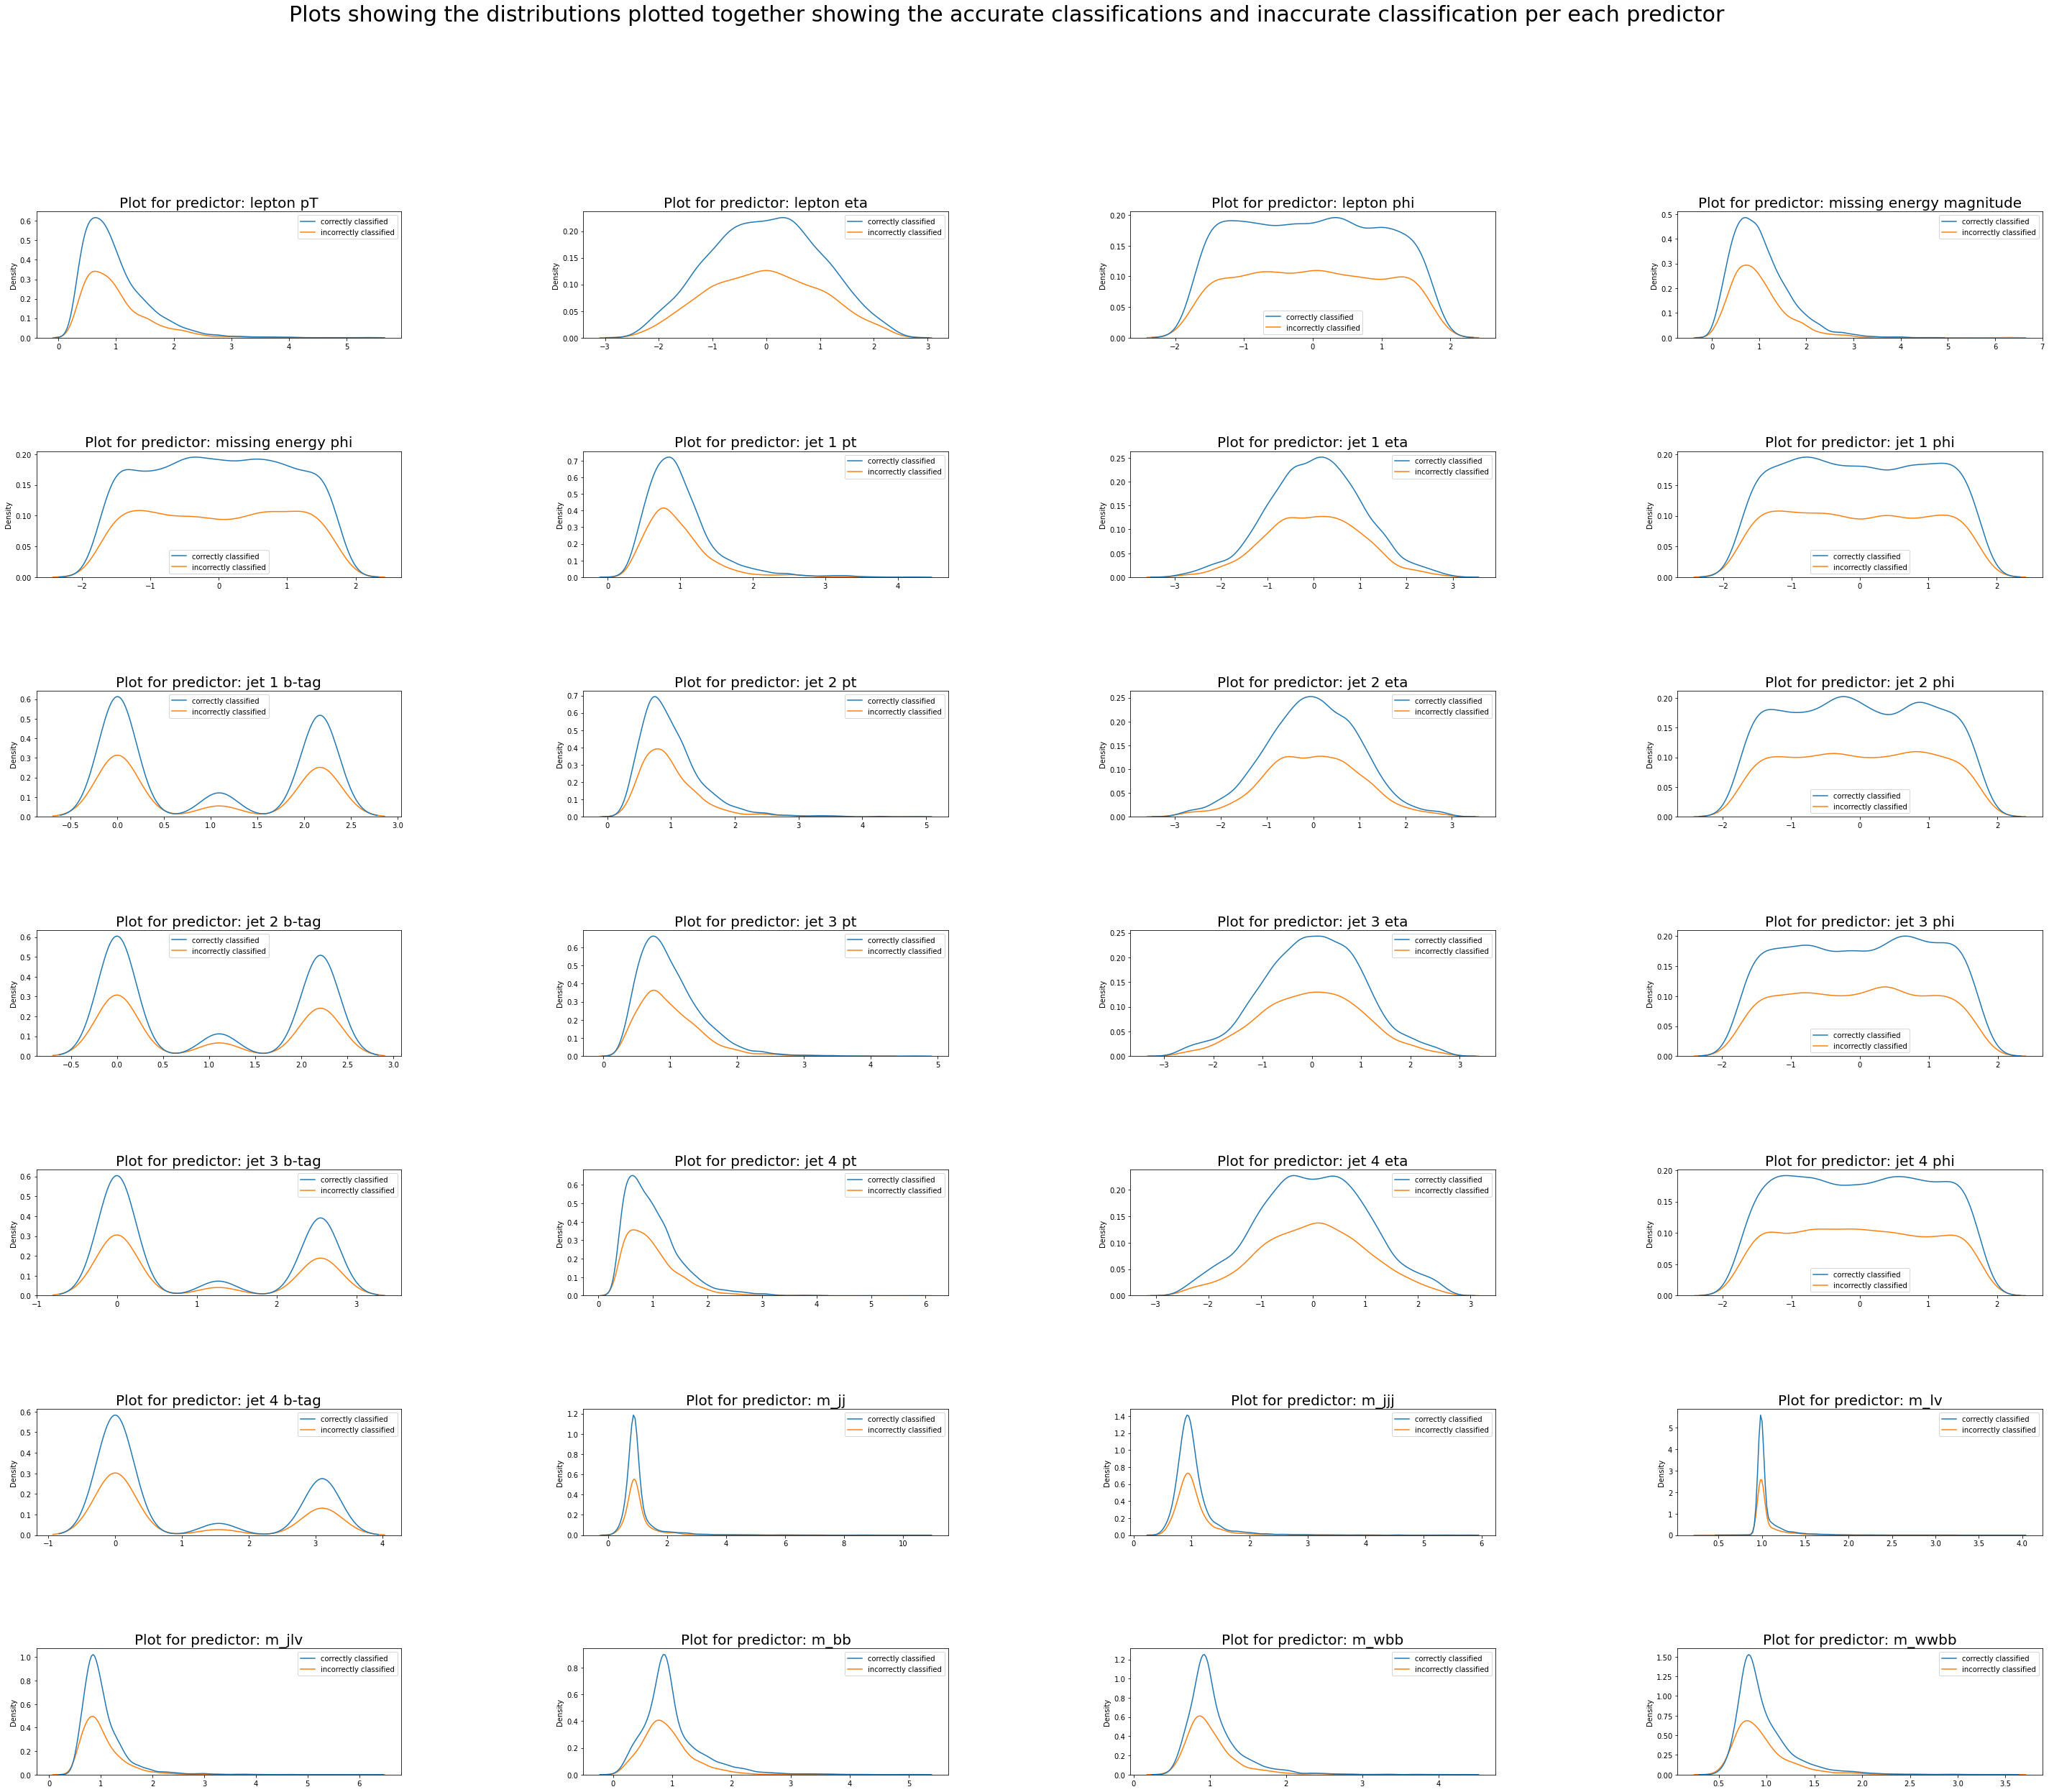

In [32]:

fig, axs = plt.subplots(7, 4, figsize = (50, 40))
fig.subplots_adjust(hspace=.9, wspace=0.5)
axs = axs.flatten()

plt.suptitle("Plots showing the distributions plotted together showing the accurate classifications and inaccurate classification per each predictor", size = 30)

for i, name in enumerate(predictors_list):
    #print(name)
    #ax = axs[i]
    sns.kdeplot(ax = axs[i], data={"correctly classified": X_accurate[:,i], "incorrectly classified": X_not_accurate[:,i]})
    ###sns.histplot(ax = axs[i], data={"correctly classified": X_accurate[:,i], "incorrectly classified": X_not_accurate[:,i]}, kde = True)
    axs[i].set_title(f"Plot for predictor: {name}", size = 20)


 

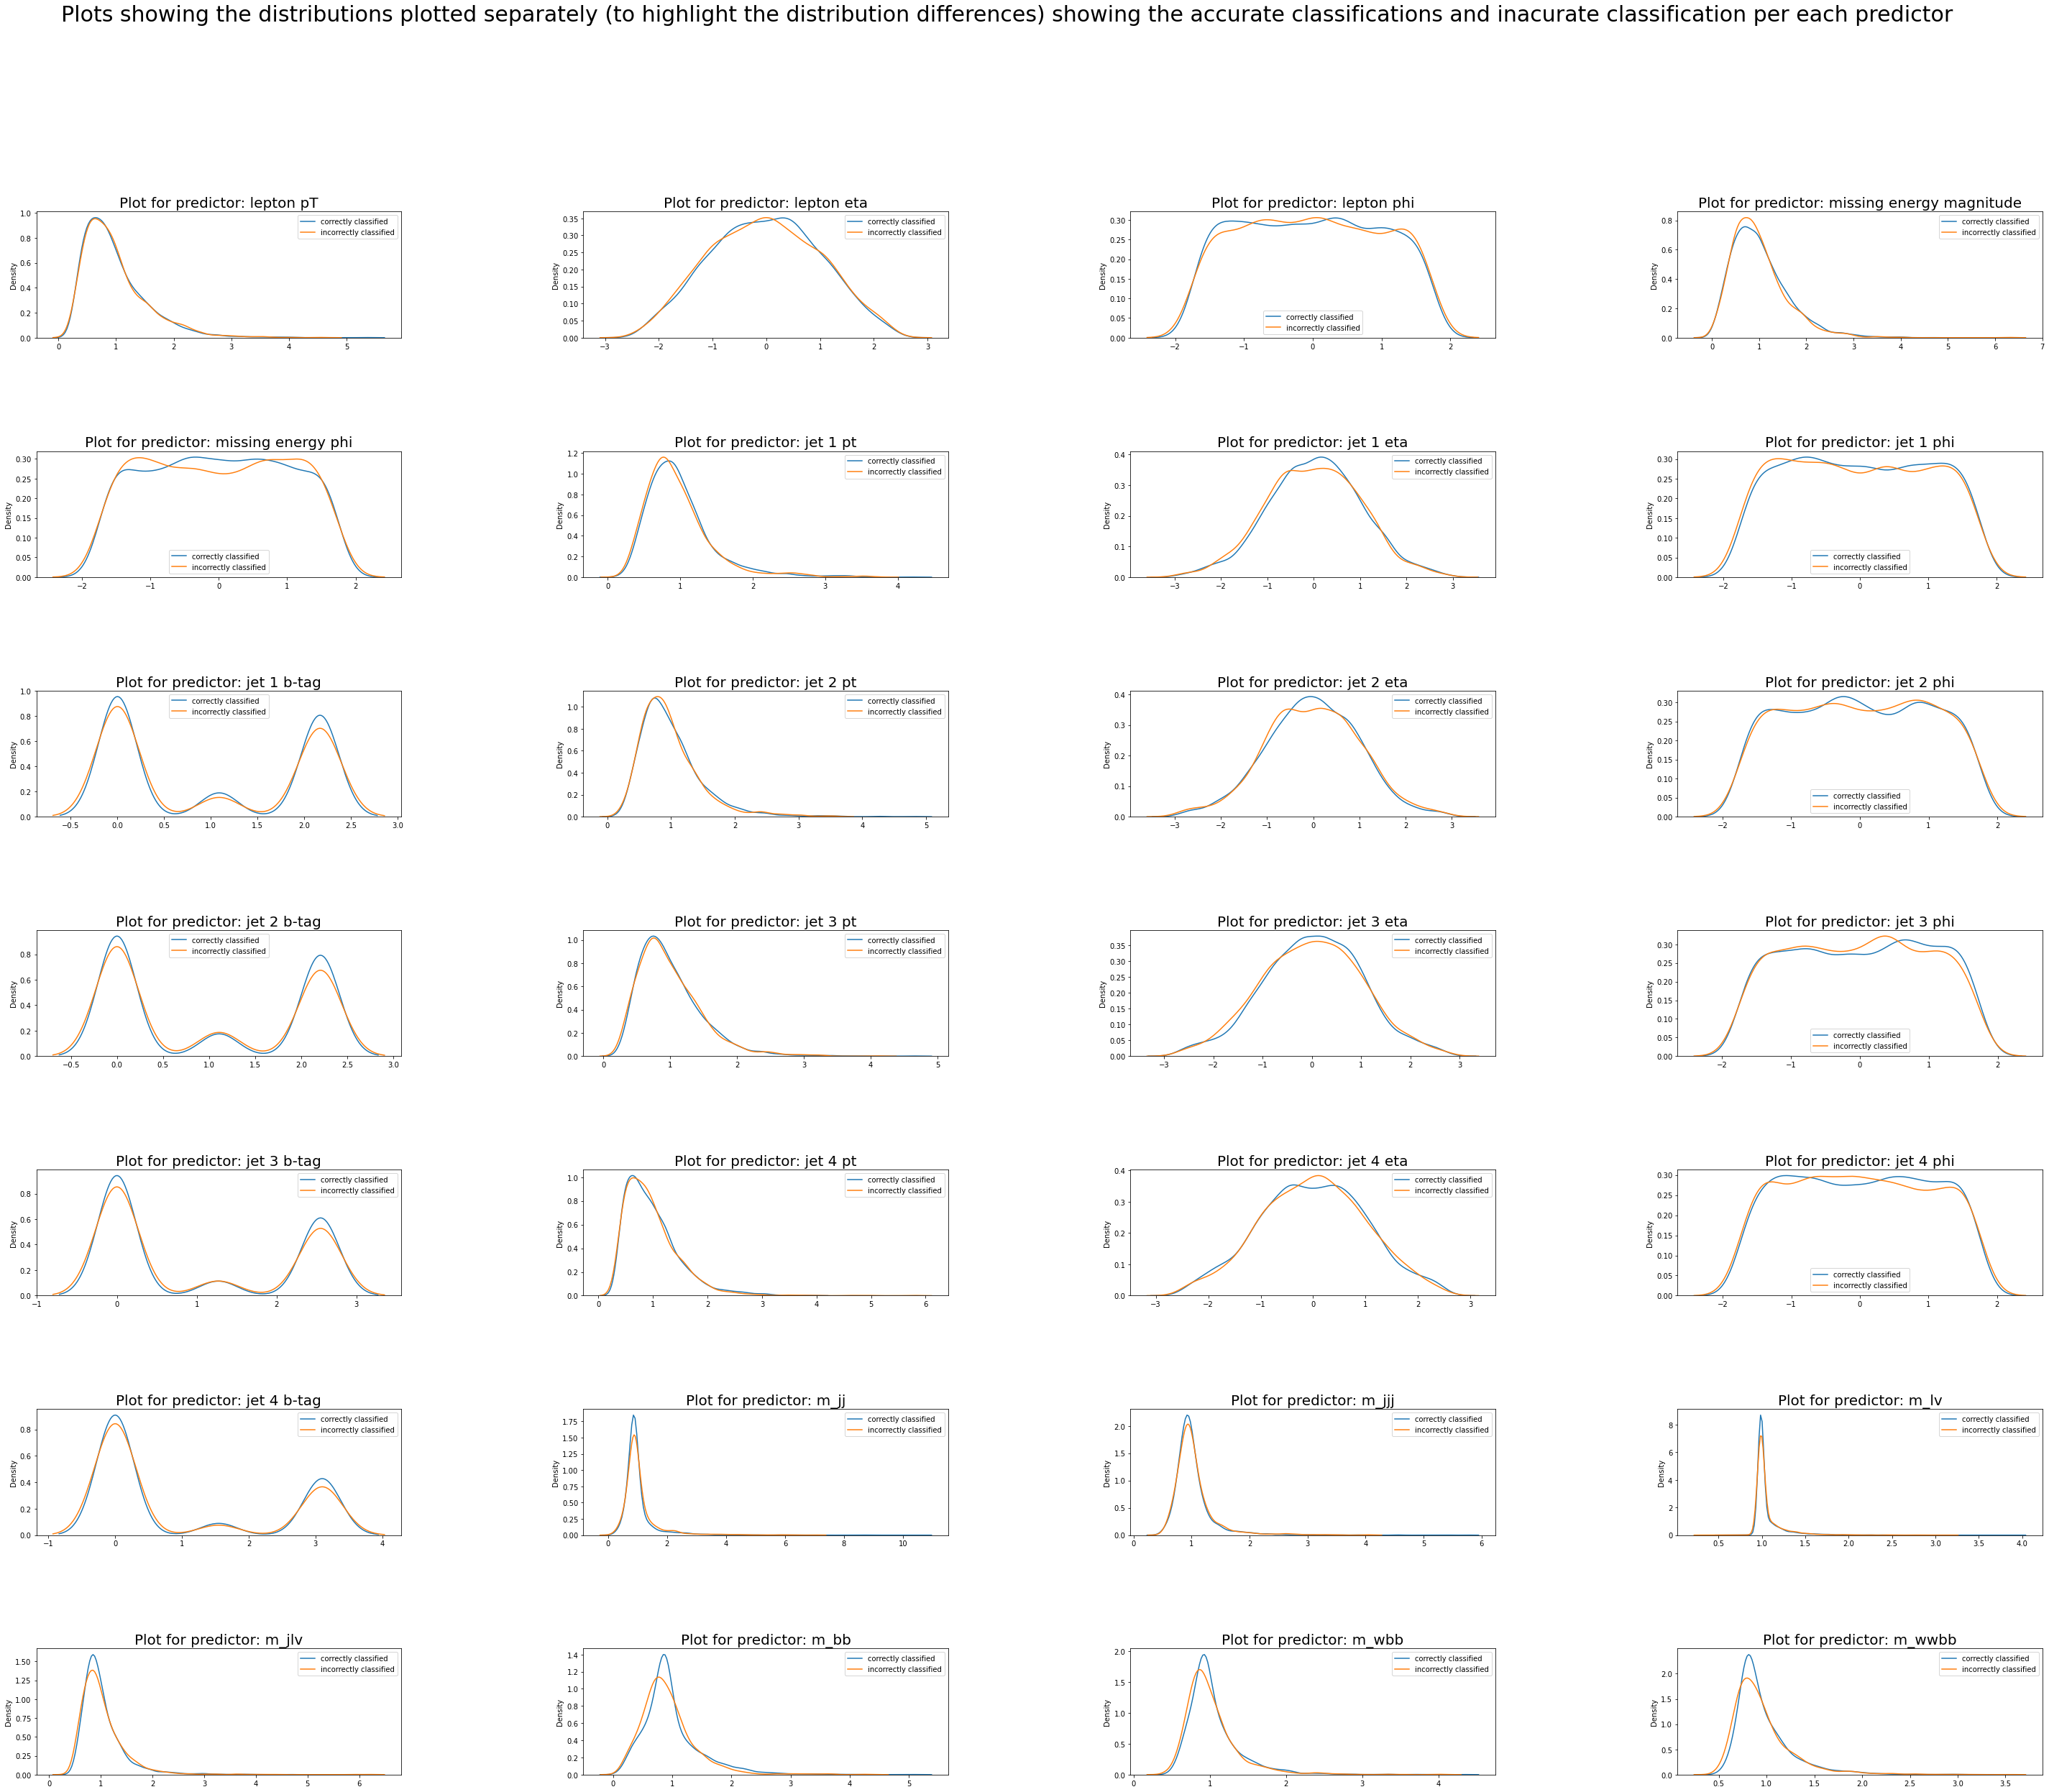

In [33]:

fig, axs = plt.subplots(7, 4, figsize = (50, 40))
fig.subplots_adjust(hspace=.9, wspace=0.5)
axs = axs.flatten() #ravel # to have a single index 

plt.suptitle("Plots showing the distributions plotted separately (to highlight the distribution differences) showing the accurate classifications and inacurate classification per each predictor", size = 30)


for i, name in enumerate(predictors_list):
    #print(name)
    #ax = axs[i]
    sns.kdeplot(ax = axs[i], data=X_accurate[:,i], label = "correctly classified")
    
    sns.kdeplot(ax = axs[i], data =X_not_accurate[:,i], label = "incorrectly classified")
    axs[i].legend(loc='best')
    
    ###sns.histplot(ax = axs[i], data={"correctly classified": X_accurate[:,i], "incorrectly classified": X_not_accurate[:,i]}, kde = True)
    axs[i].set_title(f"Plot for predictor: {name}", size = 20)
 

**Comments:**

* The orange line is the distrubution of incorrectly classified predictions and the blue line if for correctly classified predictions. I can see that for all predictors the orange line is always below the blue line. Meaning that all these predictors classify more correnctly than incorrectly. Meaning, these are good predictors. 

**Do you notice any predictors for which the distributions are clearly different?**

* I can't notice anywhere the distributions are **majorly** different. Mostly the distributions are the same, the hights might differ between correctly/incorrectly classified, but the distrubution of correnctly and incorrectly classified is the same for each predictor.
* In some cases the distributions are **minorly** different, such as:
    * predictor m_bb: at around 1 the distributions look slightly different, meaning that there are more correct classifications than incorrect
    * predictor jet 4 eta, at around 0, the distributions look slightly different, where at around 0 there are more incorrect classifications than correct
    * predictor jet 2 eta, at around 0, the distributions look slightly different, where at around 0 there are more correct classifications than incorrect
    * predictor missing energy phi, the distributions overlap at the endings, whereas bewteern -2 and 2 they don't
    * etc. 
    

<div class='exercise-r'>

**4.2** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

In [34]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


In [35]:
# RUN THIS CELL
# "Attempted" boosting implementation

############################
# Here I am fixing this code
############################


##### Mistake 1#
# There should be more arguments in this function, otherwise
# you would have to do train test split of X and y inside, which I don't think it's a good idea.

def boostmeup(X_train, y_train, X_test, y_test): #(x, y)
  
    ##### Mistake #2
    # You need to have a new tree from scratch every time you want to fit it.
    # Both tree2 and tree1 were fitting on the same tree called tree. That is not ok
    # because you are refitting the same tree after it has been refitted, you are not referring to the
    # original virgin tree. 
    # Hence, you need a new tree every time.
    tree1 = DecisionTreeClassifier(max_depth=3)
    #tree = DecisionTreeClassifier(max_depth=3) ## This is wrong
    tree1 = tree1.fit(X_train, y_train)
    
    sample_weight = np.ones(len(X_train)) #as many as many rows #all the rows have the same weight of 1
    q = 0 #count of iteration where it's wrong
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1 #this is the count for missclassification
    
    ### Mistake #3
    # What they were callinc accuracy is actually the missclassificaiton rate. This is because 
    # q is a count where 1 is added every time that my prediction does NOT match the real y value. 
    # Hence, q is how many times I got my prediction wrong.
    
    print("tree1 missclassification:", q / len(X_train))
    print("tree1 accuracy:", (1- (q / len(X_train))))
    
    #### THEY FORGOT TO PRINT THE TEST ACCURACY 
    
    ### Mistake #4
    # See above, you need a new tree.
    tree2 = DecisionTreeClassifier(max_depth=3)
    tree2 = tree2.fit(X_train, y_train, sample_weight=sample_weight)
    
    # If i were to continue this, i would predict on tree2 and tree1 and take the average of these predictions
    # and then create a new sample weight 
    # and then use that new sample weight to fit a new tree3
    
#----------------------------
# Train
    q = 0
    
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            # if >0.5, i predicted y =1
            
            #### Stylistic flaw:
            # I changed this to 1 because I think that is more intuitive and more useful for our context. 
            if y_train[idx] == 1: #changed, 1 is more intuitive
                q = q + 0 
                # means that my classificaiton is rtight 
            else: #false, y train ! = 1 , 
                q = q + 1 #Adding 1 for when the prediction doesnt match the real y value
                
                
        else: # m =< 5 # if i predicted 0
            if y_train[idx] == 1:
                q = q + 1
            else: # and y = 0
                ### Mistake 5#
                # q is not 0 other qise you are erasing all the progress and counts made so far
                q = q
                
    ### Mistake 6#
    # Same as above in mistake #3. 
    print("Boosted missclassification train:", (q / len(X_train)))             
    print("Boosted accuracy train:", (1- (q / len(X_train))))
    

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_test[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_test[idx] == True:
                q = q + 1
            else:
                ### Mistake 7
                # q is not 0 other qise you are erasing all the progress and counts made so far
                q =q 
                
    ### Mistake 8#
    # Same as above in mistake #3. 
    print("Boosted missclassification test:", (q / len(X_test)))
    print("Boosted accuracy test:", (1- (q / len(X_test))))
  

boostmeup(X_train, y_train, X_test, y_test)

tree1 missclassification: 0.3582
tree1 accuracy: 0.6417999999999999
Boosted missclassification train: 0.3512
Boosted accuracy train: 0.6488
Boosted missclassification test: 0.349
Boosted accuracy test: 0.651


**List of mistakes in the code above:**

I have also decided to fix the mistakes, see cell above.

Mistakes:

* 1. The arguments of the functions cannot be X and y. If that is the case, then inside the function we would need to do a train test split. I find that unnecessary, because the user will have done that already outside that function. Consequently, it makes more sennse to have as arguments of the funcitons X_train, y_train, X_test, y_test

* 2. Every time we fit a new tree we need to create a new virgin tree from scratch. I cannot fit on the same tree twice, because I am not referring to the original tree, but to the already modified one.  Consequentely, for tree1 and tree2 we need to create a new DecisionTreeClassifier object separatly from scratch.

* 3. In the loop we have a count q that counts (i.e. adds 1) every time we have a missclassification. I.e. every time that the prediction does not match the real y value. Consequently, $\frac{q}{len(X_train)}$ is the missclassification rate, i.e. how many I got wrong in total, and not the accuracy rate. This mistake everywhere in the code, in total **3** times. 

* 4. I think that when checking the bosted accuracy, all those loops are unnecessary as it could be done with many less lines of code. 

* 5. Additionally, y_train[idx] ==True is not intuitie in this case, it would be better to have it rather ==1 because we know that our y is either 0 or 1. 

* 6. Additionally, in those loops they set q=0 at the end. That is wrong, because it erases all the counts done up to that point. That has to be q=q. This happened **twice** both in the train and test boosting accuracy calculations. 

* 7. Another mistake: the code is printing only the train accuracy of the first tree tree1, not the test accuracy. The code should be printing both train and test accuracies of tree1. 

<div class='exercise-r'>

**4.3** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.2:

- Write an excellent example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

</div>

In [36]:
# your code here
#weak learner --> learns with almost no overgfitting

def my_booster_function(X_train, y_train, X_test, y_test):
    # FIRST SETUP
    tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
    y_pred_1 = tree1.predict(X_train)
    matches1 = (y_pred_1==y_train).astype(int) #array with 1 for true and 0 for false
    accuracy1 = matches1.mean()
    weights1 = matches1.copy()
    weights1[weights1==0]=2
    print(f"The accuracy of the single first decision tree on the train dataset with depth of 3 is {accuracy1}")
    y_pred_1_test = tree1.predict(X_test)
    matches1_test = (y_pred_1_test==y_train).astype(int) #array with 1 for true and 0 for false
    accuracy1_test = matches1_test.mean()
    print(f"The accuracy of the single first decision tree on the test dataset with depth of 3 is {accuracy1_test}")


    tree2=DecisionTreeClassifier(max_depth=3).fit(X_train,y_train, sample_weight = weights1)
    y_pred_2 = tree2.predict(X_train)
    matches2 = (y_pred_2==y_train).astype(int)
    accuracy2 = matches2.mean()
    #weights2 = matches2.copy()
    #weights2[weights2==0]=2
    print(f"The accuracy of the single second decision tree on the train dataset fitted with the weights vector with depth of 3 is {accuracy2}")

    #if I were to continue, I would fit tree 3 with the weights 2 and so on

    # --------------------------------------#

    #### TRAIN
    pred_proba1 = tree1.predict_proba(X_train)[:,1] #look at the prob that y is 1
    pred_proba2 = tree2.predict_proba(X_train)[:,1]

    probs = pd.DataFrame()
    probs['tree1 probs'] = pred_proba1
    probs['tree2 probs'] = pred_proba2
    boosted_probabilities_12 = probs.mean(axis=1) #mean across rows to collapse this to 1 column

    boosted_pred12_classified = (boosted_probabilities_12>= 0.5).astype(int)
    boosted_matches_train = (y_train == boosted_pred12_classified).astype(int)
    accuracy_boosted_train = boosted_matches_train.mean()

    print(f"The accuracy for the ada boosted model with 2 trees on the training dataset is {accuracy_boosted_train}")

    #### TEST
    pred_proba1 = tree1.predict_proba(X_test)[:,1]
    pred_proba2 = tree2.predict_proba(X_test)[:,1]

    probs = pd.DataFrame()
    probs['tree1 probs'] = pred_proba1
    probs['tree2 probs'] = pred_proba2
    boosted_pred12 = probs.mean(axis=1) #mean across rows to collapse this to 1 column

    boosted_pred12_classified = (boosted_pred12>= 0.5).astype(int)
    boosted_matches_test = (y_test == boosted_pred12_classified).astype(int)
    accuracy_boosted_test = boosted_matches_test.mean()


    print(f"The accuracy for the ada boosted model with 2 trees on the testing dataset is {accuracy_boosted_test}")
    
     
my_booster_function(X_train, y_train, X_test, y_test)

The accuracy of the single first decision tree on the train dataset with depth of 3 is 0.6418
The accuracy of the single first decision tree on the test dataset with depth of 3 is 0.5004
The accuracy of the single second decision tree on the train dataset fitted with the weights vector with depth of 3 is 0.6134
The accuracy for the ada boosted model with 2 trees on the training dataset is 0.6488
The accuracy for the ada boosted model with 2 trees on the testing dataset is 0.651


<div class='exercise-r'>

**4.4** Now, let us use the scikit-learn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and test accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

In [37]:
# your code here

boost4_4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), algorithm = 'SAMME.R', learning_rate = 0.05, n_estimators = 800)
boost4_4.fit(X_train, y_train)
scores_train = list(boost4_4.staged_score(X_train, y_train))
scores_test = list(boost4_4.staged_score(X_test, y_test))

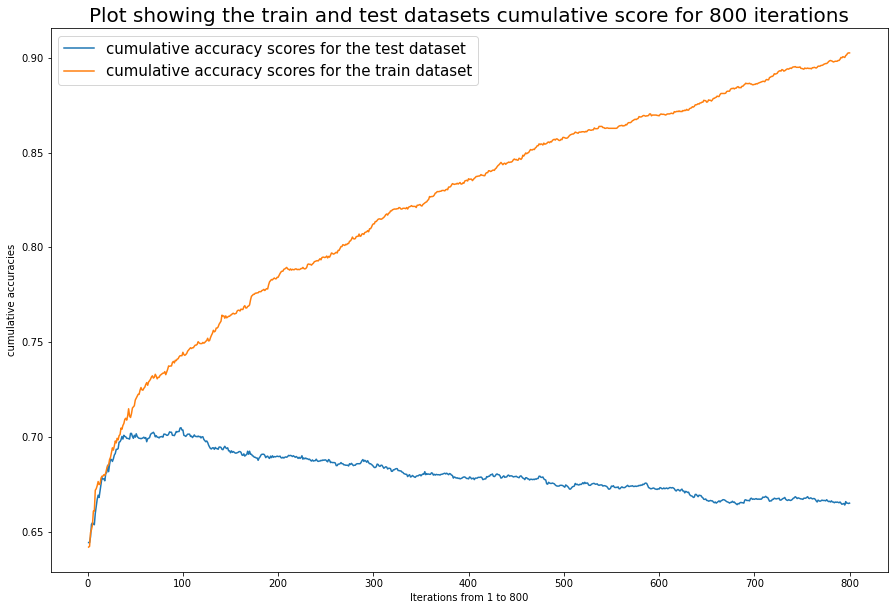

In [38]:
plt.figure(figsize=(15, 10))
plt.plot(np.linspace(1, 800, 800), scores_test, label = "cumulative accuracy scores for the test dataset" )
plt.plot(np.linspace(1, 800, 800), scores_train, label = "cumulative accuracy scores for the train dataset")
plt.legend(fontsize = 15)
plt.xlabel("Iterations from 1 to 800")
plt.ylabel("cumulative accuracies")
plt.title("Plot showing the train and test datasets cumulative score for 800 iterations", fontsize = 20)
plt.show()


In [39]:
# the best depth is the one that maximises the accuracy cvmeans
highest_accuracy_ada_test = max(scores_test)
best_n_trees = scores_test.index(highest_accuracy_ada_test)+1 #this is the best depth, which is 5
accuracy_ada_train = scores_train[best_n_trees]

print("The ideal n of trees  in Adaboost (with the trees of depth 3) that maximises the testing accuracy is the n. of tree of :", best_n_trees,". ")
print("This n. of trees leads to the testing accuracy of : ", highest_accuracy_ada_test*100, "%")
print("This n. of trees leads to the train accuracy of : ", accuracy_ada_train*100, "%")

The ideal n of trees  in Adaboost (with the trees of depth 3) that maximises the testing accuracy is the n. of tree of : 98 . 
This n. of trees leads to the testing accuracy of :  70.48 %
This n. of trees leads to the train accuracy of :  74.28 %


<div class='exercise-r'>

**4.5** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. Therefore, you should end up with 4 separate plots or subplots. What trends do you see in the training and test accuracy?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

In [40]:
# your code here
scores_train_45 = []
scores_test_45 = []



for i in range(1, 5):

    boost4_4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), algorithm = 'SAMME.R', learning_rate = 0.05, n_estimators = 800)
    boost4_4.fit(X_train, y_train)
    scores_train_iteration = list(boost4_4.staged_score(X_train, y_train))
    scores_test_iteration = list(boost4_4.staged_score(X_test, y_test))
    scores_train_45.append(scores_train_iteration)
    scores_test_45.append(scores_test_iteration)


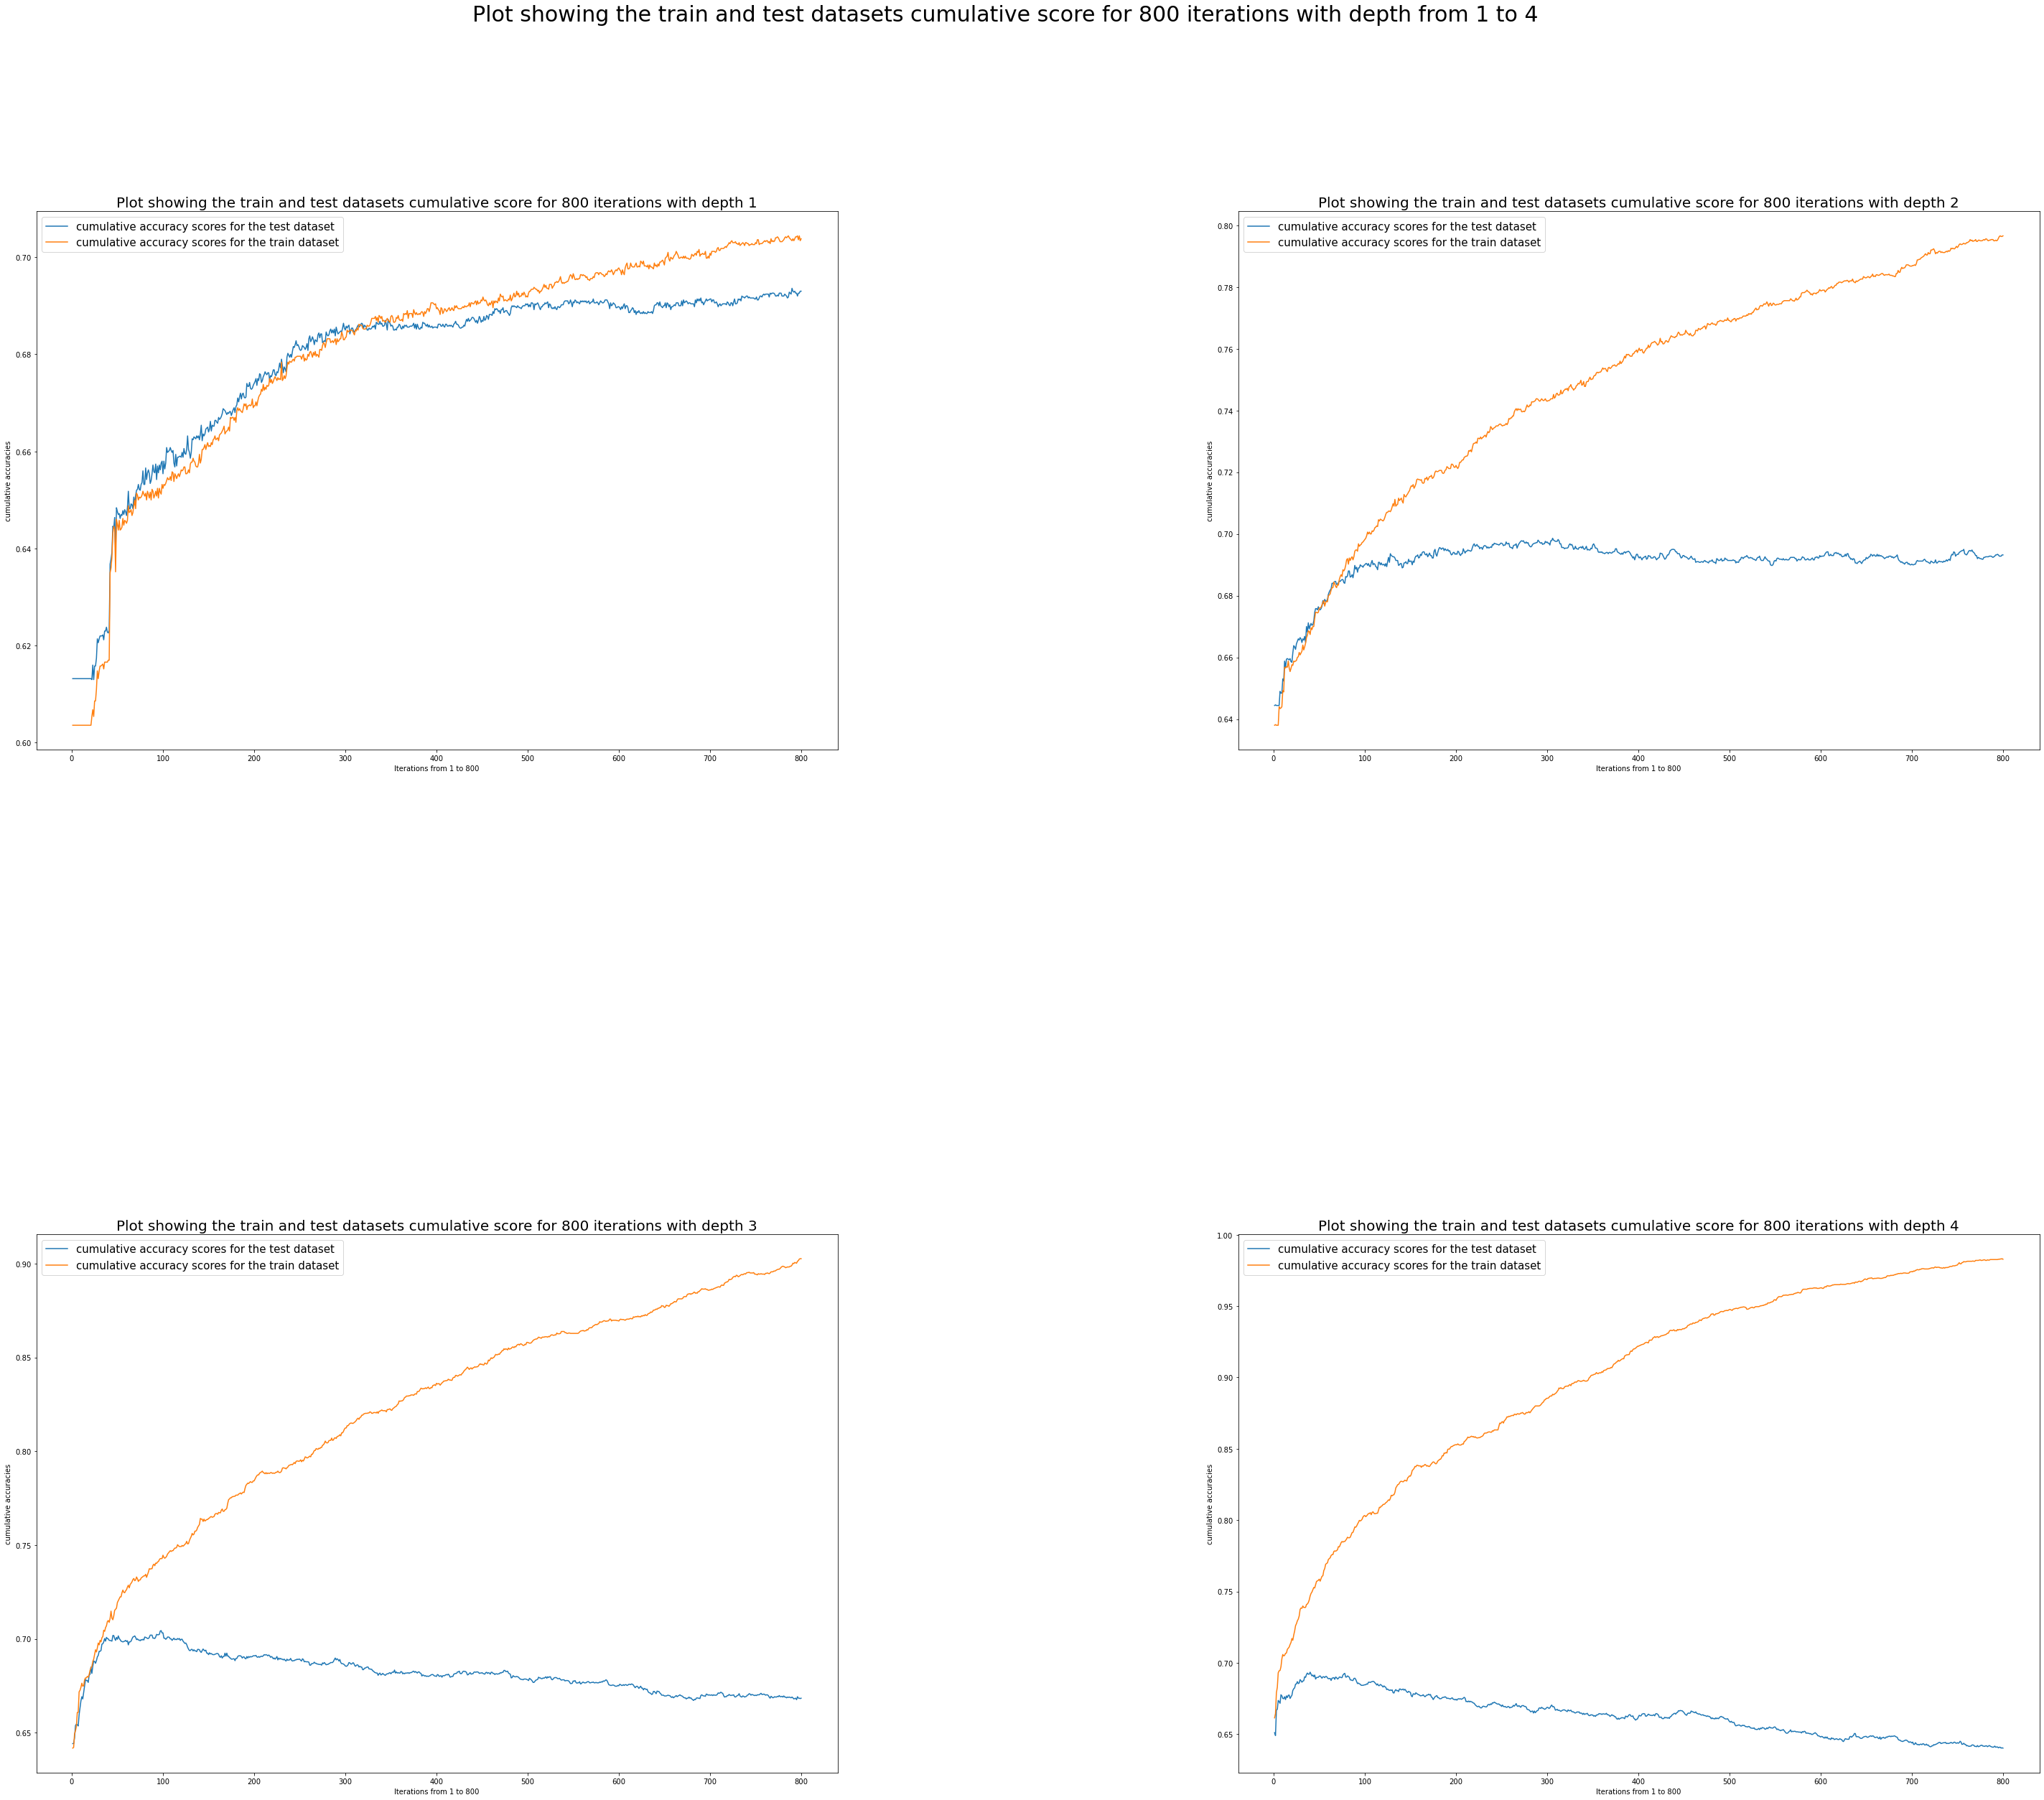

In [41]:


fig, axs = plt.subplots(2, 2, figsize = (50, 40))
fig.subplots_adjust(hspace=.9, wspace=0.5)
axs = axs.flatten()

plt.suptitle("Plot showing the train and test datasets cumulative score for 800 iterations with depth from 1 to 4", size = 30)

for i in range(0,4):

    axs[i].plot(np.linspace(1, 800, 800), scores_test_45[i], label = "cumulative accuracy scores for the test dataset" )
    axs[i].plot(np.linspace(1, 800, 800), scores_train_45[i], label = "cumulative accuracy scores for the train dataset")
    axs[i].legend(fontsize = 15)
    axs[i].set_xlabel("Iterations from 1 to 800")
    axs[i].set_ylabel("cumulative accuracies")
    axs[i].set_title(f"Plot showing the train and test datasets cumulative score for 800 iterations with depth {i+1}", fontsize = 20)




* **Boosting**: boosting is the process of starting with a very underfit tree  and hence start from a low variance/high bias situation, to gradually overfit and increase the variance to degrese the bias. 

* In this case, adaboost is starting from a very underfit tree, and fitting another tree based on the mistakes (weights) that the previous tree did. In our exercise, we are doing this for 800 times and we start with a tree of depth 3. 

**What trends do you see in the training and test accuracy?**

* In the case of base learner with depth 1: 
    * increasing the number of boosted trees with AdaBoost does not lead to overfitting on the training data set. Meaning that both training dataset as well as testing dataset accuracies are close/similar, as seen from the first plot. 

* In the case of base learner with depth 2/3/4: 
    * increasing the number of boosted trees with AdaBoost does lead to overfitting, as the training and testing score curves diverge. Meaning that both training dataset as well as testing dataset accuracies are very far apart, as seen from the second, third and fourth plot. 

* In the case of base learner with depth 2: 
    * increasing the number of boosted trees with AdaBoost does not lead to major improvements on the performance on the testing dataset. As new trees are added, the performance on the test first improves and then plateus. 
    
* Contrarily, In the case of depth 3 and 4:  
    * increasing the number of boosted trees initially increases the performance on the test, but eventually it starts to  decrease the performance on the testing dataset. 




<div class='exercise-r'>

**4.6** Answer the following interpretive questions. The use of code is optional here, but should be used if you find it is needed to answer any of these questions. 

</div>

In [42]:
test_depth1 = scores_test_45[0]
test_depth2 = scores_test_45[1]
test_depth3 = scores_test_45[2]
test_depth4 = scores_test_45[3]

train_depth1 = scores_train_45[0]
train_depth2 = scores_train_45[1]
train_depth3 = scores_train_45[2]
train_depth4 = scores_train_45[3]


In [43]:
highest_test_score_depth1 = max(test_depth1)
best_n_trees1 = test_depth1.index(highest_test_score_depth1)+1 
train_score_depth1 = train_depth1[best_n_trees1]

highest_test_score_depth2 = max(test_depth2)
best_n_trees2 = test_depth2.index(highest_test_score_depth2)+1 
train_score_depth2 = train_depth1[best_n_trees2]

highest_test_score_depth3 = max(test_depth3)
best_n_trees3 = test_depth3.index(highest_test_score_depth3)+1 
train_score_depth3 = train_depth1[best_n_trees3]

highest_test_score_depth4 = max(test_depth4)
best_n_trees4 = test_depth4.index(highest_test_score_depth4)+1 
train_score_depth4 = train_depth1[best_n_trees4]


score_1to4 = pd.DataFrame()
score_1to4['depth'] = [1,2,3,4]
score_1to4['highest test accuracy']= [highest_test_score_depth1, highest_test_score_depth2, highest_test_score_depth3, highest_test_score_depth4]
score_1to4['ideal amount of boosted trees']= [best_n_trees1, best_n_trees2, best_n_trees3, best_n_trees4]
score_1to4['training score']=[train_score_depth1, train_score_depth2, train_score_depth3, train_score_depth4]

score_1to4

,depth,highest test accuracy,ideal amount of boosted trees,training score
0,1,0.6936,790,0.7038
1,2,0.6986,306,0.6850
2,3,0.7044,98,0.6532
3,4,0.6934,40,0.6170


<div class='exercise-r'>

**4.6.1** Based on the plots from Question 4.5, what combination of base learner depth and the number of iterations seems optimal and why?

</div>

The highest test accuracy is reached with 0.7046 with depth 3. Hence the base learner of depth 3 is the best one. This is optimal with 98 iterations, i.e. with 98 boosted trees.

<div class='exercise-r'>

**4.6.2** Why should we be hesitant to select our learner depth and number of iterations hyperparameters based on our inspection of these train and test results? What are the risks of doing so?

</div>

We should be hesitant to select our learner depth and number of iterations hyperparameters on test/train results because if we pick what best performs on test we are basically cheating. 

We want to pick a model that best performs on the validation set, we want to tune our hyperparamenters on the validation set (possibly, on several validation sets, i.e. cross validating). We should avoid tuning the model on the test set.

This is the case because the test set is supposedly the 'real' world data we will use our model on. If we pick the 'best model' on the test, we basically would be overfitting on the test, which is cheating. 
Consequently, althought adaboost here seems better, we can't say that this model would perform better on new unseen data from the world.

The point of CV is to avoid overfitting on the test, that's why we fine tune hyperparameters on validation, and **not** on test dataset.


In this problem set, we fine tuned the adaboost model on the testing dataset, which leads to a wrong assessment of its performance on the test. If it has been fine tuned on the test, clearly it will perform well on the test as well. 





<div class='exercise-r'>

**4.6.3** Setting those risks aside, if you do select the base learner depth and number of iterations based on those plots, how does the performance of that model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

In [44]:

table = pd.DataFrame()
table['classifier'] = ['single depth-i tree chosen by CV', 'single overfit depth-k tree', 'bagging 55 depth-k trees', 'random forest of 55 depth-k trees', 'ada boost with trees depth-3 and 98 trees']
table['training accuracy'] = [best_cv_tree_train_score, worst_cv_tree_train_score,bagging_accuracy_train,  random_forest_train_score, accuracy_ada_train]
table['test accuracy'] = [best_cv_tree_test_score,worst_cv_tree_test_score, bagging_accuracy_test, random_forest_test_score , highest_accuracy_ada_test]
table



,classifier,training accuracy,test accuracy
0,single depth-i tree chosen by CV,0.6812,0.6478
1,single overfit depth-k tree,0.9998,0.5976
2,bagging 55 depth-k trees,0.9994,0.6884
3,random forest of 55 depth-k trees,1.0000,0.6898
4,ada boost with trees depth-3 and 98 trees,0.7428,0.7048



**From previous questions:** 
* Question 2: Bagging. Test accuracy was 68.84%.
* Question 3: Random Forest. Test accuracy was 68.72%.

**Ada boost with base learner depth-3 and 98 boosted trees:**
* If we ignore the fact that the adaboost model was fine tuned incorrectly on the test set:
    * Compared to the bagging and to the RF models, Adaboosts does "better" than these on the testing set. Hence, Adaboost "outperforms" RF and bagging, becuase its accuracy on the test dataset is higher, meaning 70.40%. 

<a id="part5"></a>

## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

**5.5** Which of these techniques can be extended to regression tasks? How?

<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

In [45]:

table = pd.DataFrame()
table['classifier'] = ['single depth-i tree chosen by CV', 'single overfit depth-k tree', 'bagging 55 depth-k trees', 'random forest of 55 depth-k trees', 'ada boost with trees depth-3 and 98 trees']
table['training accuracy'] = [best_cv_tree_train_score, worst_cv_tree_train_score,bagging_accuracy_train,  random_forest_train_score, accuracy_ada_train]
table['test accuracy'] = [best_cv_tree_test_score,worst_cv_tree_test_score, bagging_accuracy_test, random_forest_test_score , highest_accuracy_ada_test]
table


,classifier,training accuracy,test accuracy
0,single depth-i tree chosen by CV,0.6812,0.6478
1,single overfit depth-k tree,0.9998,0.5976
2,bagging 55 depth-k trees,0.9994,0.6884
3,random forest of 55 depth-k trees,1.0000,0.6898
4,ada boost with trees depth-3 and 98 trees,0.7428,0.7048


<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

**Commonalities between boosting and bagging:** 
* They both are ensable models, meaning that they combine the usage of several base models
* They both start from an "extreme" (boosting: low bias/high variance, bagging: high bias/low variance) to then tone down to an ideal prediction.

**Boosting:**
* Boosting is performed iteratively, each iteration depends on the previous one
* Boosting starts with a base learner that is very weak learner, i.e. that is more likely to underfit (very low depth in the case of trees). This means that boosting starts with a model that tendially underfits, i.e. from high bias and low variance. Gradually, boosting adds complexity to the model (by fitting to its previous residuals for example, as in the case of gradient boosting, or by weigting the mistakes more harshly, as in the case of adaboost). Meaning, that boosting adds variance and reduces bias gradually at every iteration/additional boosted model. 

**Bagging:**
* Bagging can be performed in a parallelized fashion, because each iteration is independent from the previous one
* Bagging starts with a base learner that is very strong learner, i.e. that is more likely to overfit (very high depth in the case of trees). This means that bagging starts with a model that tendially overfits, i.e. from low bias and high variance. Gradually, bagging removes complexity from the model (by aggregating/averaging, such as in Bagging and in RF). Meaning, that bagging reduces variance and adds bias gradually at every bootstrap/iteration. 


<div class='exercise-r'>

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

</div>

**Overall best performance:**


Throughout this problem set, Ada boost (with a base learner of depth-3) is the model that performs the best.
However, this happened due to an imprecise process in our calculations.

This is imprecise because for the models above (bagging and random forest) we were finding the best model based on **validation** scores, and not based on **test** scores. 
The model of Adabost that is the "best" (i.e. 98 trees and depth 3), was picked based on **test** scores, and not **validation** scores. This can be seen as a kind of cheating.

Consequently, the correct approach with adaboost would have been to do CV, and pick the best number of depth and trees based on CV. 

As a conclusion, we actually do not know which model **actually** performs best here. It seems that Adaboost did, but this assesstment is based on test scores and not on validation scores, as it was for the other models in this problem set. 

<div class='exercise-r'>

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>



* In **bagging**, an additional/marginal tree is as bad as the other ones, consequently the marginal addition at first improves the model, but at a certain point usually it doesn't start to harm but it rather simply makes the performance plateu.
     

* On the other hand in **boosting**, at every new iteration I am fixing all my mistakes, meaning that at first the model perfomance improves. However eventually the marginal addition of a new tree can lead to overfitting. Hence it is **worst** to have too many trees in **boosting**, as too many tree will eventually overfit.  
    * As an example from this problem set: as we can see from the graphs of 4.4, in boosting, if we have too many trees (too many boosted trees), we can get to overfitting (i.e. the divergence between test and training performance increases). 


<div class='exercise-r'>

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

**Parallelization** (multithreading for example) in computing means to split tasks and do them simultaneously (parallelize), i.e. to process data in parallel. 

Consequently, **bagging** is better suited for parallelization. 

Boosting cannot be parallelized because in boosting the next iteration depends on the previous one (on the errors/mistakes of the previous model).  Whereas in parallelization, we can parallelize tasks that are independent from each other.

In bagging, we can parallelize these tasks as we can estimate the base estimators independently at each task (at each bootstrap).

<div class='exercise-r'>

**5.5** Which of these techniques can be extended to regression tasks? How?

</div>



Both Bagging and Boosting can be extended to do regression tasks. 

What changes is that we need to change the base estimator model (classifier in this case) to be a regression model. 

For example:

* In **bagging**, we could use as base estimator a Decision Tree Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) instead of the DecisionTreeClassifier. Also, we could use a typical LinearRegression. As done above, we would choose a high depth for the base tree. Altenatively, if we were using a LinearRegression, we could pick a polynomial with high degrees. 
As performed above, if we pick regression models as base model, what we would do in bagging would be to aggregate this ( average them ), as we did for the classification case.

* In **boosting**, we could use as base estimator a Decision Tree Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) instead of the DecisionTreeClassifier. Also, we could use a typical LinearRegression. As done above, we would choose a very low for the base tree. Altenatively, if we were using a LinearRegression, we could pick a polynomial with low degrees. 

* In the case of **boosting** we would have to be careful simply to perform Gradient Boosting correctly and Adaboost correctly, as they differ in structure. For gradient boosting, we would be fitting on the residuals iteratively, meaning that the next base model is fitted on the residuals of the previous one. Whereas on Adaboost, in the next iteration,  the next base bodel will take into account weights, where these weights will weight more harshly the predictions predicted wrong. 




#### THE END

[Return to contents](#contents)